# LSTM Model Many to One (Attention)
# Environment Package:
# Numpy, Keras(Tensorflow), Scikit-Learn, Pandas, Matplotlib, 
# Attention(API)↓ 
# https://github.com/philipperemy/keras-attention-mechanism

In [2]:
import os
import pandas as pd, sys
from datetime import datetime
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib
from matplotlib import pyplot
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import sklearn
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import load_model, Model
print('Scikit-Learn:',sklearn.__version__)
print('Numpy:',np.__version__)
print('Pandas:',pd.__version__)
print('Matplotlib:',matplotlib.__version__)

Scikit-Learn: 0.24.1
Numpy: 1.19.2
Pandas: 1.1.5
Matplotlib: 3.3.4


In [4]:
print('env pass')

env pass


In [5]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [6]:
n_features = 1
n_steps = 30
scaler = MinMaxScaler(feature_range=(0, 1))
def data_load(path_):
    df = read_csv(path_)
    df_n = np.array([[i[1]] for i in df.values])
    date_df = np.array([[i[0]] for i in df.values])
    df_n = scaler.fit_transform(df_n)
    # data subgroup train = train_len, test = total - train_len
    train_len = len([i for i in date_df.flatten() if ('2015' in i)!=True])
    Train_sub = df_n[:train_len]
    Test_sub = df_n[train_len:]
    X_T, y_T = split_sequence(Train_sub, 30)
    X_t, y_t = split_sequence(Test_sub, 30)
    print('Total Len = ',len(date_df.flatten()) ,'  Train Len = ',len(Train_sub), '  Test Len = ',len(Test_sub))
    return X_T, y_T, X_t, y_t, df_n

In [7]:
def model_class(model_name, X_T, y_T, X_t, y_t, units, att_status):
    model_input = Input(shape=(n_steps, n_features))
    if 'base' in model_name:
        x = LSTM(units, activation='tanh', return_sequences=att_status)(model_input)

    elif 'stack' in model_name:
        x = LSTM(units, activation='tanh', return_sequences=True)(model_input)
        x = LSTM(units//2, activation='tanh', return_sequences=att_status)(x)

    elif 'bidirect' in model_name:
        x = Bidirectional(LSTM(units, activation='tanh', return_sequences=att_status))(model_input)
    

    x = Dense(1)(x)
    model = Model(model_input, x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    print(f'----------start train {model_name}----------')
    history = model.fit(X_T, y_T, epochs=50, validation_data=(X_t, y_t), verbose=0)
    print(f'----------start test {model_name}----------')
    trainPred = model.predict(X_T)
    testPred = model.predict(X_t)
    
    return history, trainPred, testPred



In [8]:
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
data_stack=['Linkou3.csv','Keelung.csv','Taipei.csv','Yunlin.csv']
# model_list = ['base lstm', 'stack lstm', 'bidirect lstm', 'base lstm attention', 'stack lstm attention', 'bidirect lstm attention']
model_list = ['base lstm', 'stack lstm', 'bidirect lstm']
all_branch_train_pred=[]
all_branch_test_pred=[]
for path in data_stack:
    print(f'Dataset: {path[:-4]}')
    train_pred_list=[]
    test_pred_list=[]
    histroy_list=[]
    X_T, y_T, X_t, y_t, _ = data_load(path)
    for i in model_list:
        att_status = False
        history, trainPred, testPred = model_class(i, X_T, y_T, X_t, y_t, 100, att_status)
        train_pred_list.append(trainPred)
        test_pred_list.append(testPred)
        histroy_list.append(history)
    all_branch_train_pred.append(train_pred_list)
    all_branch_test_pred.append(test_pred_list)
    
    # plot history logs [train loss, test loss]
    for j in range (len(histroy_list)):
        fig = plt.figure(figsize=(15,5))
        plt.plot(histroy_list[j].history['loss'], label='train')
        plt.plot(histroy_list[j].history['val_loss'], label='test')
        plt.title(f'{model_list[j]}')
        plt.legend()
        if not os.path.exists(f'Results/{path[:-4]}'):
            os.makedirs(f'Results/{path[:-4]}')
        plt.savefig(f'Results/{path[:-4]}/ Results Plot test - {path[:-4]} Branch - {model_list[j]}.jpg')
        plt.cla()
        plt.clf()
        plt.close()

pass
Dataset: Linkou3
Total Len =  2996   Train Len =  2641   Test Len =  355
----------start train base lstm----------
----------start test base lstm----------
pass
----------start train stack lstm----------
----------start test stack lstm----------
pass
----------start train bidirect lstm----------
----------start test bidirect lstm----------
pass
pass
Dataset: Keelung
Total Len =  2908   Train Len =  2543   Test Len =  365
----------start train base lstm----------
----------start test base lstm----------
pass
----------start train stack lstm----------
----------start test stack lstm----------
pass
----------start train bidirect lstm----------
----------start test bidirect lstm----------
pass
pass
Dataset: Taipei
Total Len =  3028   Train Len =  2663   Test Len =  365
----------start train base lstm----------
----------start test base lstm----------
pass
----------start train stack lstm----------
----------start test stack lstm----------
pass
----------start train bidirect lstm------

In [9]:
# invert predictions
def data_rescaler(input_data):
    output_data = scaler.inverse_transform(input_data)
    return output_data


In [10]:
import math
from keras import backend as K
from keras.metrics import mean_absolute_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Total Len =  2996   Train Len =  2641   Test Len =  355


/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


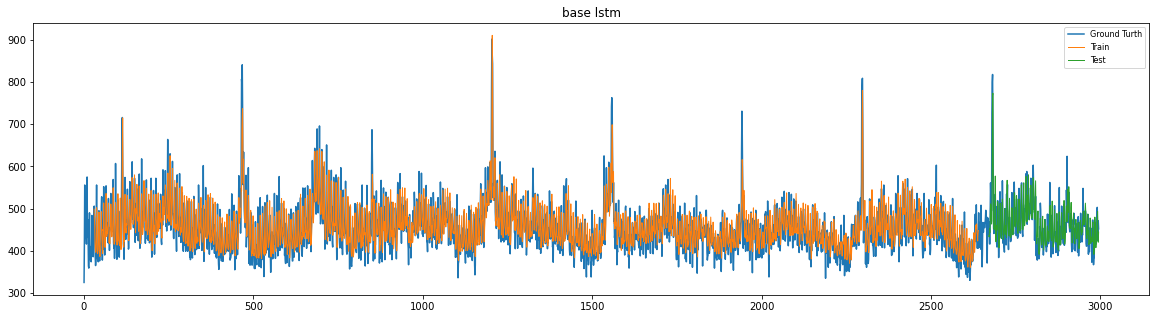

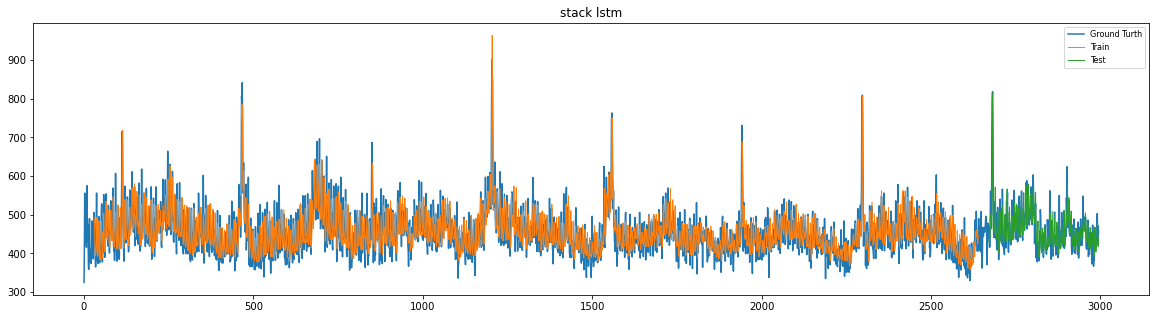

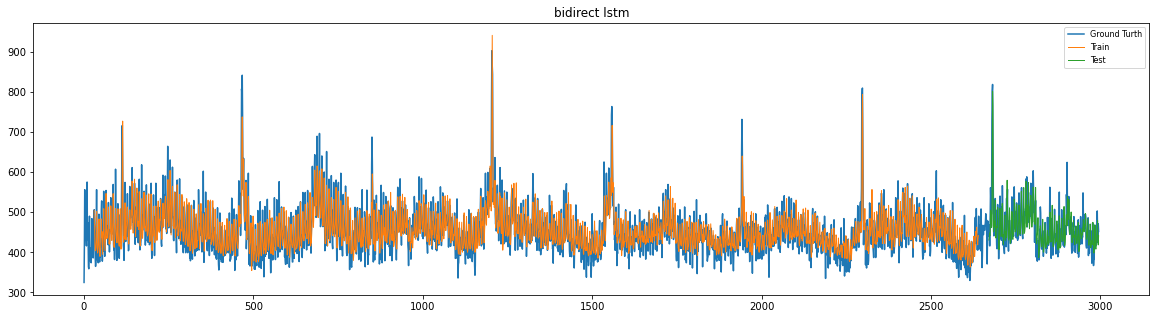

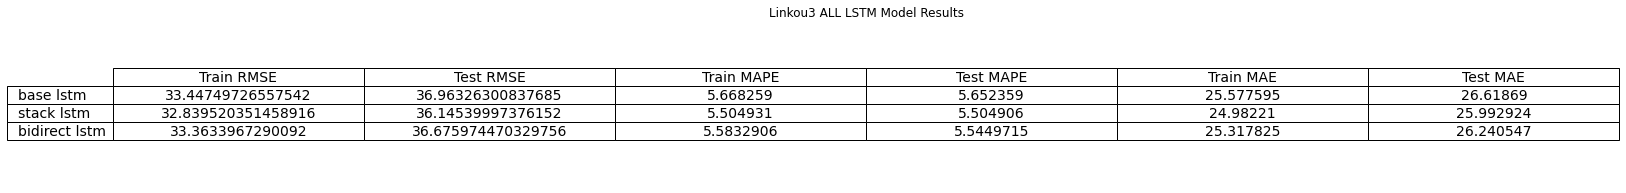

Total Len =  2908   Train Len =  2543   Test Len =  365


/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


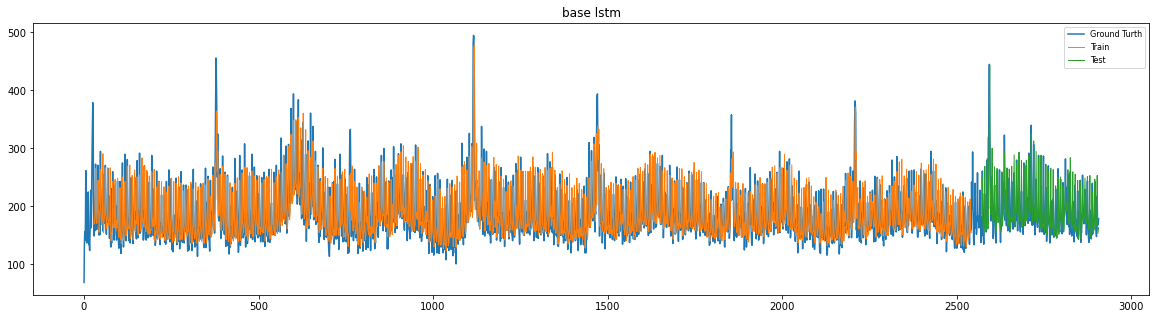

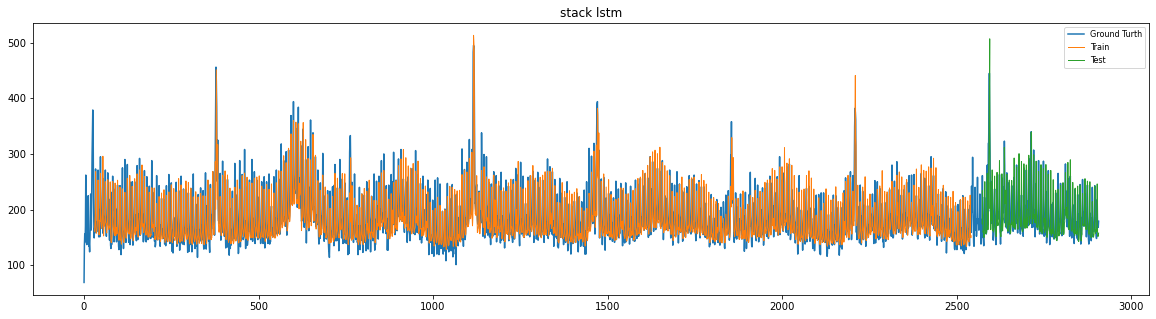

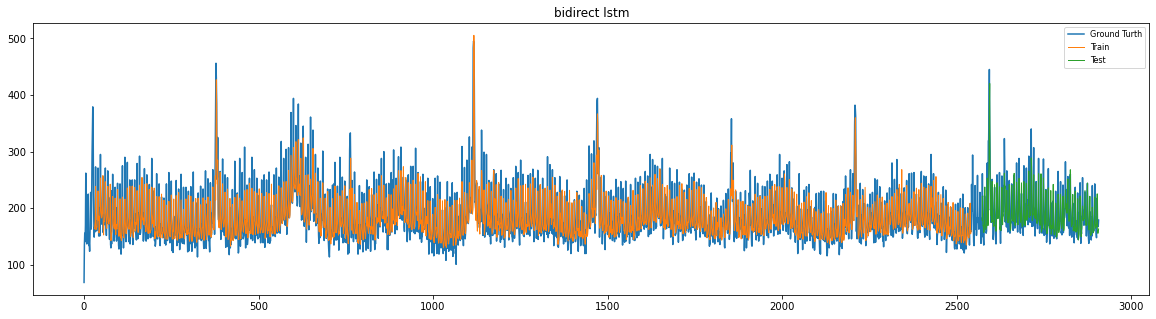

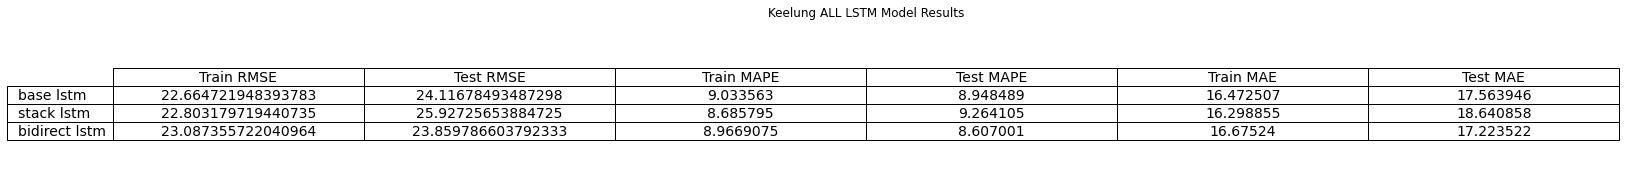

Total Len =  3028   Train Len =  2663   Test Len =  365


/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


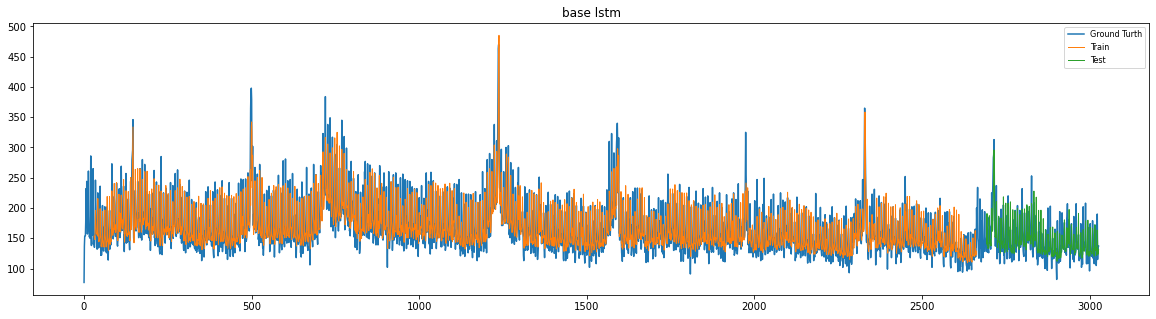

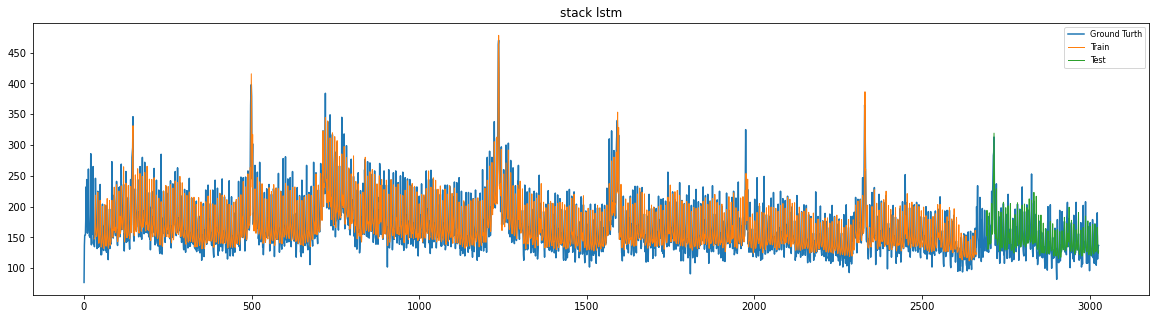

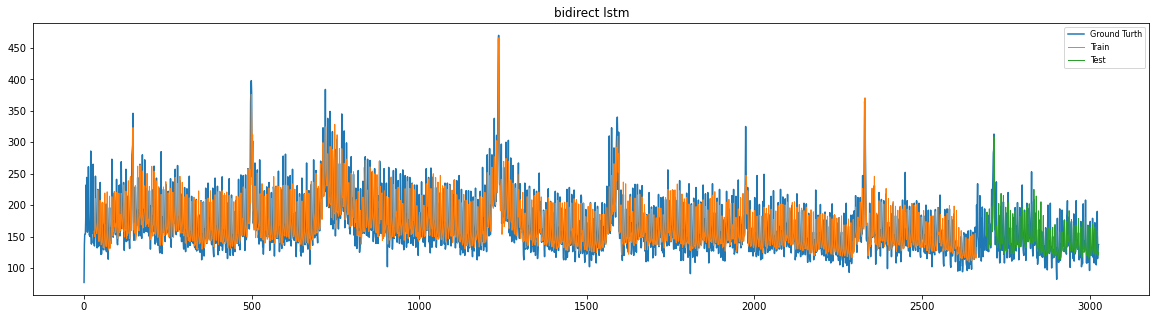

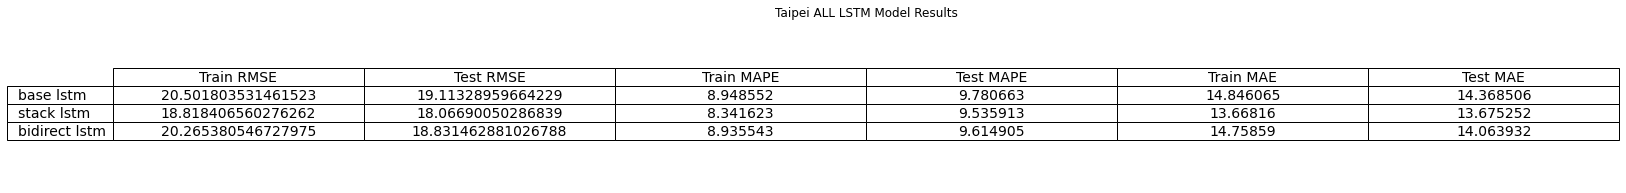

Total Len =  2191   Train Len =  1826   Test Len =  365


/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


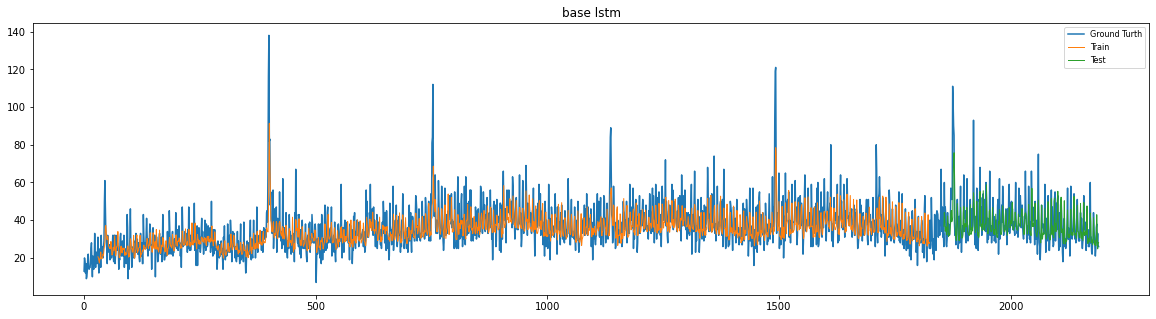

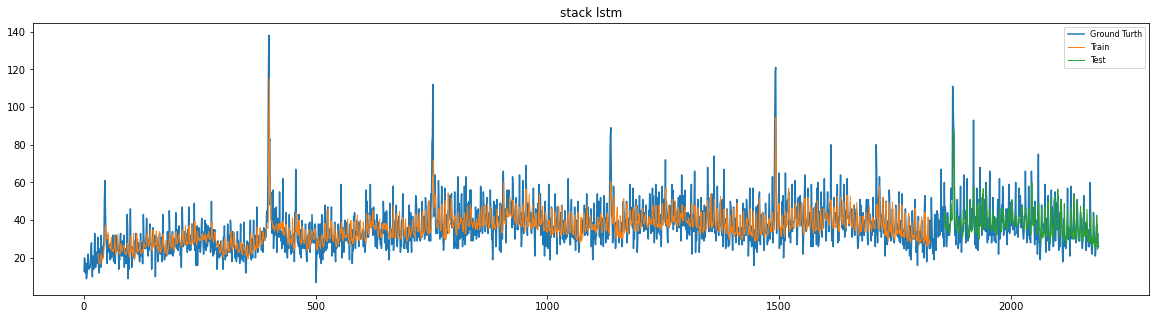

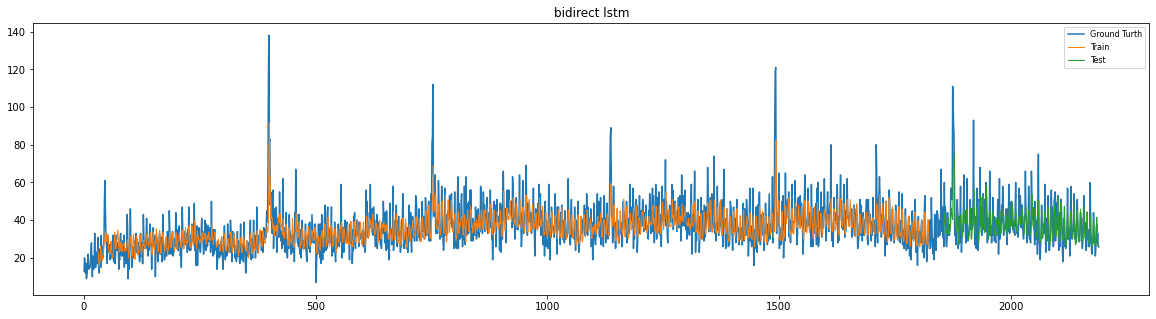

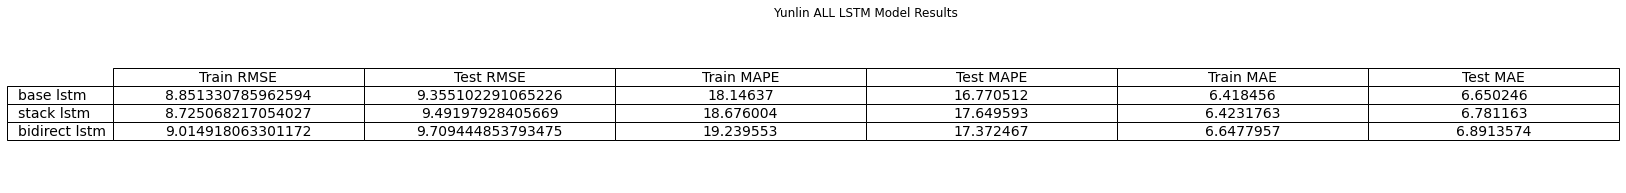

In [11]:
# metric code
# matplotlib.use('Agg')
metric_list = ['Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE', 'Train MAE', 'Test MAE']
for idx, branch in enumerate(data_stack):
    _, y_T, _, y_t , df_n= data_load(branch)
    train_pred_list = all_branch_train_pred[idx]
    test_pred_list = all_branch_test_pred[idx]
    model_metric_stack=[]
    for i in range(len(model_list)):
        all_metric_stack = []
        trainY = data_rescaler(y_T)
        testY = data_rescaler(y_t)
        trainPredict = data_rescaler(train_pred_list[i])
        testPredict = data_rescaler(test_pred_list[i])
        # print(trainY.shape, testY.shape, trainPredict.shape, testPredict.shape)
        # RMSE
        all_metric_stack.append((root_mean_squared_error(trainY[:,0], trainPredict[:,0])).numpy())
        all_metric_stack.append((root_mean_squared_error(testY[:,0], testPredict[:,0])).numpy())
        # MAPE
        all_metric_stack.append((mean_absolute_percentage_error(trainY[:,0], trainPredict[:,0])).numpy())
        all_metric_stack.append((mean_absolute_percentage_error(testY[:,0], testPredict[:,0])).numpy())
        # MAE
        all_metric_stack.append((mean_absolute_error(trainY[:,0], trainPredict[:,0])).numpy())
        all_metric_stack.append((mean_absolute_error(testY[:,0], testPredict[:,0])).numpy())
        model_metric_stack.append(all_metric_stack)

        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(df_n)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[30:len(trainPredict)+30, :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = np.empty_like(df_n)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+60:, :] = testPredict
        # plot baseline and predictions
        plt.figure(figsize=(20,5))
        plt.title(f'{model_list[i]}')
        plt.plot(scaler.inverse_transform(df_n), linewidth=1.5, label = 'Ground Turth')
        plt.plot(trainPredictPlot, linewidth=1, label='Train')
        plt.plot(testPredictPlot, linewidth=1, Label='Test')
        plt.legend(fontsize=8)
        if not os.path.exists(f'Results/{branch[:-4]}'):
            os.makedirs(f'Results/{branch[:-4]}')
        plt.savefig(f'Results/{branch[:-4]}/{branch[:-4]} - {model_list[i]} plot baseline and predictions test.jpg')
        # plt.cla()
        # plt.clf()
        # plt.close()





    plt.figure(figsize=(18, 3))
    plt.axis('off')
    plt.axis('tight')
    plt.title(f'{branch[:-4]} ALL LSTM Model Results')
    tab1 = plt.table(cellText=model_metric_stack, rowLabels = model_list, colLabels=metric_list, cellLoc='center',loc='center')
    tab1.scale(1.5,1.5)
    tab1.set_fontsize(14)
    plt.savefig(f'Results/{branch[:-4]} Performance Table.jpg', bbox_inches="tight")
    plt.show()